In [1]:
import pandas as pd
data = pd.read_csv('../data/data.csv')

### Define X and Y

In [2]:
X=data.drop(columns=['EmployeeCount','StandardHours','Over18','EmployeeNumber','TrainingTimesLastYear','HourlyRate','Attrition'])
y=data['Attrition']

### Split data 

In [3]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)

### Pipeline construction 


 ENTRAÎNEMENT DES MODÈLES AVEC GRIDSEARCHCV
Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\user\Documents\formation simplon ai\briefs\RetentionAI_Employee_Churn Prediction_HR_Decision_Support_System\RetentionAI-backend\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


meilleur score CV: 0.8308
meilleurs paramètres: {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Fitting 5 folds for each of 108 candidates, totalling 540 fits
meilleur score CV: 0.8287
meilleurs paramètres: {'model__max_depth': 20, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 100}

COMPARAISON DES PERFORMANCES

TABLEAU COMPARATIF DES PERFORMANCES
             Modèle  Accuracy  Precision  Recall  F1-Score  ROC-AUC  CV Score
Logistic Regression    0.8946       0.75  0.3077    0.4364   0.7903    0.8308
      Random Forest    0.8707       0.60  0.0769    0.1364   0.7430    0.8287


 COURBES ROC


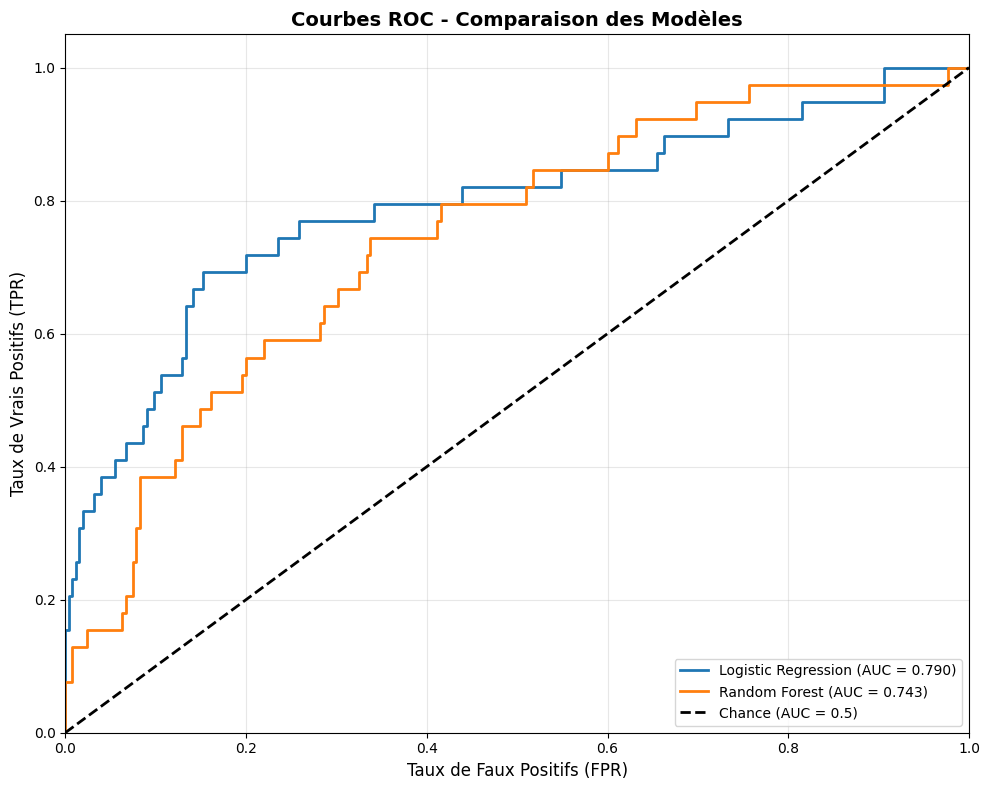


 ÉVALUATION DÉTAILLÉE PAR MODÈLE


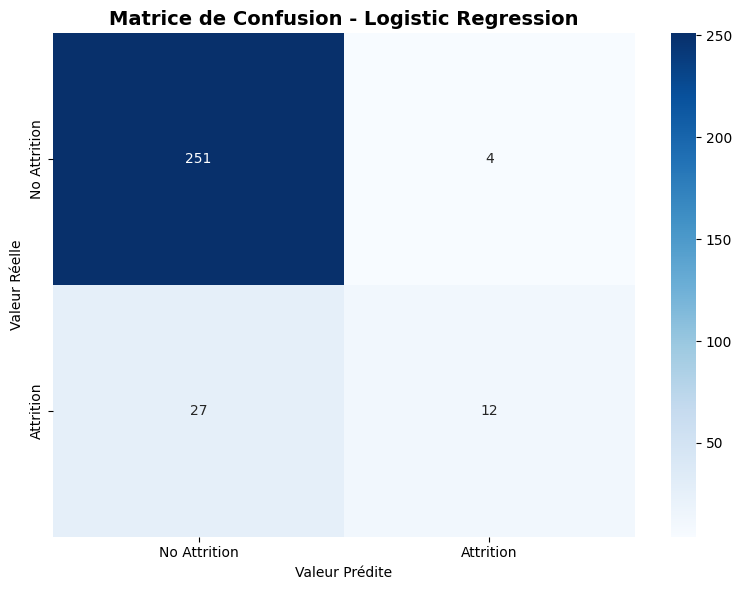

RAPPORT DE CLASSIFICATION - Logistic Regression
              precision    recall  f1-score   support

No Attrition       0.90      0.98      0.94       255
   Attrition       0.75      0.31      0.44        39

    accuracy                           0.89       294
   macro avg       0.83      0.65      0.69       294
weighted avg       0.88      0.89      0.87       294



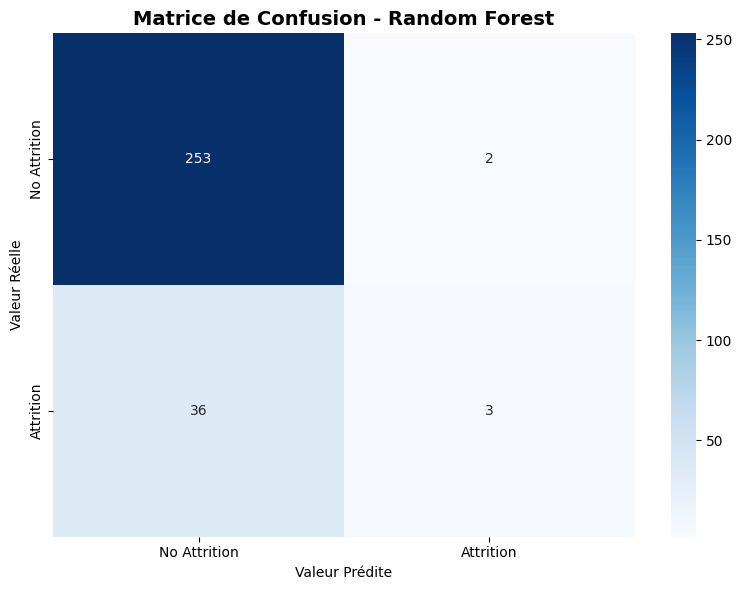

RAPPORT DE CLASSIFICATION - Random Forest
              precision    recall  f1-score   support

No Attrition       0.88      0.99      0.93       255
   Attrition       0.60      0.08      0.14        39

    accuracy                           0.87       294
   macro avg       0.74      0.53      0.53       294
weighted avg       0.84      0.87      0.82       294


 MEILLEUR MODÈLE: GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'DailyRate',
                                                                          'DistanceFromHome',
                                                                          'MonthlyIncome',
             

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report, 
                             roc_curve, roc_auc_score, accuracy_score,
                             precision_score, recall_score, f1_score)

# definition des columns
cat_cols = ['BusinessTravel', 'Department', 'JobRole', 'MaritalStatus', 'OverTime']
num_cols = ['Age', 'DailyRate', 'DistanceFromHome', 'MonthlyIncome', 'MonthlyRate', 
            'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 
            'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 
            'YearsWithCurrManager']
encoded_cols=['Education','EnvironmentSatisfaction','JobInvolvement','JobLevel','JobSatisfaction',
              'PerformanceRating','RelationshipSatisfaction','StockOptionLevel','WorkLifeBalance']
# preprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('passthrough', 'passthrough', encoded_cols),
    ]
)

# model difinition 
modelsConfig = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'model__C': [0.01, 0.1, 1, 10, 100],
            'model__penalty': ['l2'],
            'model__solver': ['lbfgs', 'liblinear']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [10, 20, 30, None],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        }
    },
}
#  Trains multiple models with hyperparameter tuning
def train_models(X_train, y_train):
    trained_models = {}
    
    for model, config in modelsConfig.items():
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', config['model'])
        ])
        
        gridSearchCv = GridSearchCV(
            pipeline,
            param_grid=config['params'],
            cv=5,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1
        )
        gridSearchCv.fit(X_train, y_train)
        
        print(f"meilleur score CV: {gridSearchCv.best_score_:.4f}")
        print(f"meilleurs paramètres: {gridSearchCv.best_params_}")
        
        trained_models[model] = gridSearchCv
    
    return trained_models
# matrice de confusion 

def matriceDeConfusion(y_true, y_pred, model):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Attrition', 'Attrition'],
                yticklabels=['No Attrition', 'Attrition'])
    plt.title(f'Matrice de Confusion - {model}', fontsize=14, fontweight='bold')
    plt.ylabel('Valeur Réelle')
    plt.xlabel('Valeur Prédite')
    plt.tight_layout()
    plt.show()
    
    return cm

# COURBE ROC
def plot_roc_curve(models_dict, X_test, y_test):

    plt.figure(figsize=(10, 8))
    
    for model, gridSearchCv in models_dict.items():
        # predictions probabilite
        y_pred_proba = gridSearchCv.predict_proba(X_test)[:, 1]
        # calcule roc
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label='Yes')
        auc_score = roc_auc_score(y_test, y_pred_proba)
        
        plt.plot(fpr, tpr, linewidth=2, 
                label=f'{model} (AUC = {auc_score:.3f})')
    # Ligne diagonale
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Chance (AUC = 0.5)')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
    plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
    plt.title('Courbes ROC - Comparaison des Modèles', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# rapport de classification
def print_classification_report(y_true, y_pred, model):

    print(f"RAPPORT DE CLASSIFICATION - {model}")
    print(classification_report(y_true, y_pred, 
                                target_names=['No Attrition', 'Attrition']))

# performance comparision 
def create_comparison_table(models_dict, X_test, y_test):

    results = []
    
    for model, gridSearchCv in models_dict.items():
        y_pred = gridSearchCv.predict(X_test)
        y_pred_proba = gridSearchCv.predict_proba(X_test)[:, 1]
        
        results.append({
            'Modèle': model,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, pos_label='Yes'),
            'Recall': recall_score(y_test, y_pred, pos_label='Yes'),
            'F1-Score': f1_score(y_test, y_pred, pos_label='Yes'),
            'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
            'CV Score': gridSearchCv.best_score_
        })
    
    df_results = pd.DataFrame(results)
    df_results = df_results.round(4)
    df_results = df_results.sort_values('ROC-AUC', ascending=False)
    
    print(f"\n{'='*80}")
    print("TABLEAU COMPARATIF DES PERFORMANCES")
    print(f"{'='*80}")
    print(df_results.to_string(index=False))
    print(f"{'='*80}\n")
    
    return df_results

# fonction evaluation
def evaluate_models(X_train, X_test, y_train, y_test):
 
    print("\n ENTRAÎNEMENT DES MODÈLES AVEC GRIDSEARCHCV")
    trained_models = train_models(X_train, y_train)

    print("\nCOMPARAISON DES PERFORMANCES")
    df_results = create_comparison_table(trained_models, X_test, y_test)
    
    print("\n COURBES ROC")
    plot_roc_curve(trained_models, X_test, y_test)
    print("\n ÉVALUATION DÉTAILLÉE PAR MODÈLE")
    for model, gridSearchCv in trained_models.items():
        y_pred = gridSearchCv.predict(X_test)
        
        matriceDeConfusion(y_test, y_pred, model)
        
        print_classification_report(y_test, y_pred, model)
    
    best_model = df_results.iloc[0]['Modèle']
    best_model = trained_models[best_model]
    
    print(f"\n MEILLEUR MODÈLE: {best_model}")
    print(f"ROC-AUC: {df_results.iloc[0]['ROC-AUC']:.4f}")
    
    return trained_models, df_results, best_model
# execution
trained_models, results_df, best_model = evaluate_models(
    X_train, X_test, y_train, y_test
)

# prédictions avec le meilleur modèle
predictions = best_model.predict(X_test)
probabilities = best_model.predict_proba(X_test)


### Save model 

In [5]:
import joblib
joblib.dump(best_model, '../models/probModel.pkl')

['../models/probModel.pkl']